In [1]:
import pandas as pd
import pycountry as pc
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer

### First cleaning to delete duplicates, cleaning the nutriscore_grade column and delete columns with at least 70% of NaN

In [ ]:
df_list = []
df_combined = pd.DataFrame()

for i in range(348):
    df = pd.read_csv(f'CSV/openfoodfacts_{i}.csv', sep=',', header=0)

    # First duplicates delete
    df_cleaned = df.drop_duplicates(keep = 'first', inplace = False)
    
    # Cleaning nutriscore_grade
    index_ng = df.columns.get_loc('nutriscore_grade')

    for j in range(df_cleaned.shape[0]):
        if df_cleaned.iloc[j, index_ng] not in ["a", "b", "c", "d", "e"]:
            df_cleaned.iloc[j, index_ng] = None

    df_cleaned.dropna(subset=['nutriscore_grade'], axis=0, how='any', inplace= True)

    # Delete columns with at least 70% NaN
    percentage = 0.70

    threshold = int((1 - percentage) * df_cleaned.shape[0])

    df_cleaned.dropna(thresh=threshold, inplace= True, axis=1)

    print(df_cleaned.shape)
    
    df_list.append(df_cleaned)

df_combined = pd.concat(df_list, ignore_index=True)

df_combined.to_csv(f'cleaned_csv/openfoodfacts_cleaned.csv', index=False)

### Second cleaning to delete rows with empty nutrients and to delete duplicates on the 'brands' and 'product_name' columns

In [4]:
df = pd.read_csv('cleaned_csv/openfoodfacts_cleaned.csv', sep=',', header=0)

# Delete rows with empty nutrients
columns_100g = [col for col in df.columns if '_100g' in col]

df_cleaned = df[~df[columns_100g].isna().all(axis=1)]

# Delete duplicates on 'brands' and 'product_name'
df_cleaned.drop_duplicates(subset=['brands', 'product_name'], keep = 'first', inplace=True)

df_cleaned.to_csv('cleaned_csv/openfoodfacts_cleaned_V2.csv', index=False)

C:\Users\tiger\AppData\Local\Temp\ipykernel_32396\3602617785.py:1: DtypeWarning: Columns (0,11,20,21,22,23,26,27,39,46,49,50,51,52,53,54,74,75,76,77,78,79,81,82,83,84,86,87,88,89,90,91,92,93,94,95,97,98,99,100,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_csv/openfoodfacts_cleaned.csv', sep=',', header=0)


### Delete all columns ending with '_tag' and '_en' except for 'countries_en', 'main_category_en' and 'categrories_en'

In [3]:
df = pd.read_csv('cleaned_csv/openfoodfacts_cleaned_V2.csv', sep=',', header=0)

tag_columns_to_drop = [col for col in df.columns if col.endswith('_tag')]

excluded_columns = ['countries_en', 'main_category_en', 'categories_en']

en_columns_to_drop = [col for col in df.columns if col.endswith('_en') and col not in excluded_columns]

# Drop the filtered columns
df = df.drop(tag_columns_to_drop, axis=1)
df = df.drop(en_columns_to_drop, axis=1)

df.to_csv('cleaned_csv/openfoodfacts_cleaned_V3.csv', index=False)

C:\Users\tiger\AppData\Local\Temp\ipykernel_32344\1912257809.py:1: DtypeWarning: Columns (0,11,20,21,22,23,26,27,39,46,49,50,51,52,53,54,74,75,76,77,78,79,81,82,83,84,86,87,88,89,90,91,92,93,94,95,97,98,99,100,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_csv/openfoodfacts_cleaned_V2.csv', sep=',', header=0)


### Distribution of products per country

In [5]:
df = pd.read_csv('cleaned_csv/openfoodfacts_cleaned_V3.csv', sep=',', header=0)

# Replacing all NaN by 'unknown'
df['countries_en'] = df['countries_en'].fillna('unknown')

# Splitting the countries string and store it in the same cell as a list
df['countries_en'] = df['countries_en'].str.split(',')

# Exploding the lists into rows
df_exploded = df.explode('countries_en')

# Striping the countries names of all useless spaces (before and after the names)
df_exploded['countries_en'] = df_exploded['countries_en'].str.strip()

def is_valid_country(country):
    '''
    Checks if the name of a country is correct in a DataFrame

    Parameters:
        country: the DataFrame containing the names of the countries
    
    Return:
        True if the name of the country is valid, or if the empty cell contains 'unknown'
        False if the name of the country is invalid
    '''
    if country.lower() == 'unknown':
        return True
    try:
        pc.countries.lookup(country)
        return True
    except LookupError:
        return False

# Applying the verification to the countries column of the DataFrame
df_exploded['valid_countries'] = df_exploded['countries_en'].apply(is_valid_country)

# Deleting all rows with an incorrect country name
df_valid_countries = df_exploded[df_exploded['valid_countries'] == True]

df_valid_countries.to_csv('cleaned_csv/openfoodfacts_valid_countries.csv', index=False)

C:\Users\tiger\AppData\Local\Temp\ipykernel_32344\3620328078.py:1: DtypeWarning: Columns (0,11,20,21,22,23,26,36,43,46,47,48,49,50,51,71,72,73,74,75,77,78,79,81,82,83,84,85,86,87,88,89,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_csv/openfoodfacts_cleaned_V3.csv', sep=',', header=0)


### Splitting columns 'categories_en', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en'

In [2]:
df = pd.read_csv('cleaned_csv/openfoodfacts_valid_countries.csv', sep=',', header=0)

# List of columns
columns_list = ['categories_en', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en']

for column in columns_list:
    # For each column, replacing all NaN by 'unknown'
    df[column] = df[column].fillna('unknown')

    # Splitting the strings and store them in the same cell as a list
    df[column] = df[column].str.split(',')

    # Exploding the lists into rows
    df_exploded_name = df.explode(column)

    # Striping the names of all useless spaces (before and after the names)
    df_exploded_name[column] = df_exploded_name[column].str.strip()

df_exploded_name.to_csv('cleaned_csv/openfoodfacts_4_columns.csv', index=False)

C:\Users\tiger\AppData\Local\Temp\ipykernel_2164\1285878114.py:1: DtypeWarning: Columns (0,11,20,21,22,23,26,36,43,46,47,48,49,50,51,71,72,73,74,75,77,78,79,81,82,83,84,85,86,87,88,89,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_csv/openfoodfacts_valid_countries.csv', sep=',', header=0)


### Keeping only rows with 'countries_en' == France because France's nutriscore approach is different from other countries

In [11]:
df = pd.read_csv('cleaned_csv/openfoodfacts_4_columns.csv', sep=',', header=0)

C:\Users\tiger\AppData\Local\Temp\ipykernel_3396\2891597325.py:1: DtypeWarning: Columns (0,11,20,21,22,23,26,36,43,46,47,48,49,50,51,71,72,73,74,75,77,78,79,81,82,83,84,85,86,87,88,89,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_csv/openfoodfacts_4_columns.csv', sep=',', header=0)


In [12]:
df_filtered = df[df['countries_en'] == 'France']

### Deleting rows where 'pnns_groups_1' == 'unknown'

In [13]:
df_filtered = df_filtered[df_filtered['pnns_groups_1'] != "['unknown']"]

In [14]:
df_filtered.to_csv('cleaned_csv/openfoodfacts_france_only.csv', index=False)

### Creating a csv file with the nutrients columns only

In [39]:
list_nutrients = [col for col in df.columns if col.endswith('_100g')]

df_nutrients = df_filtered[list_nutrients]

df_nutrients.to_csv('cleaned_csv/openfoodfacts_nutrients_only.csv', index=False)

### Deleting the outliers

In [43]:
df_outliers = pd.read_csv('cleaned_csv/openfoodfacts_nutrients_only.csv', sep=',', header=0)

In [44]:
df_outliers.columns

Index(['energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'iron_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'potassium_100g', 'energy-kj_100g',
       'fruits-vegetables-nuts_100g', 'alcohol_100g'],
      dtype='object')

In [45]:
nutrients_list = ['fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'iron_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'potassium_100g', 'fruits-vegetables-nuts_100g', 'alcohol_100g']

df_filtered1 = df_outliers[nutrients_list][(df_outliers[nutrients_list] >= 0) & (df_outliers[nutrients_list] <= 100)]
df_filtered2 = df_outliers['energy-kcal_100g'][(df_outliers['energy-kcal_100g'] >= 0) & (df_outliers['energy-kcal_100g'] <= 900)]
df_filtered1['energy-kcal_100g'] = df_filtered2

display(df_filtered1.shape)

(322145, 19)

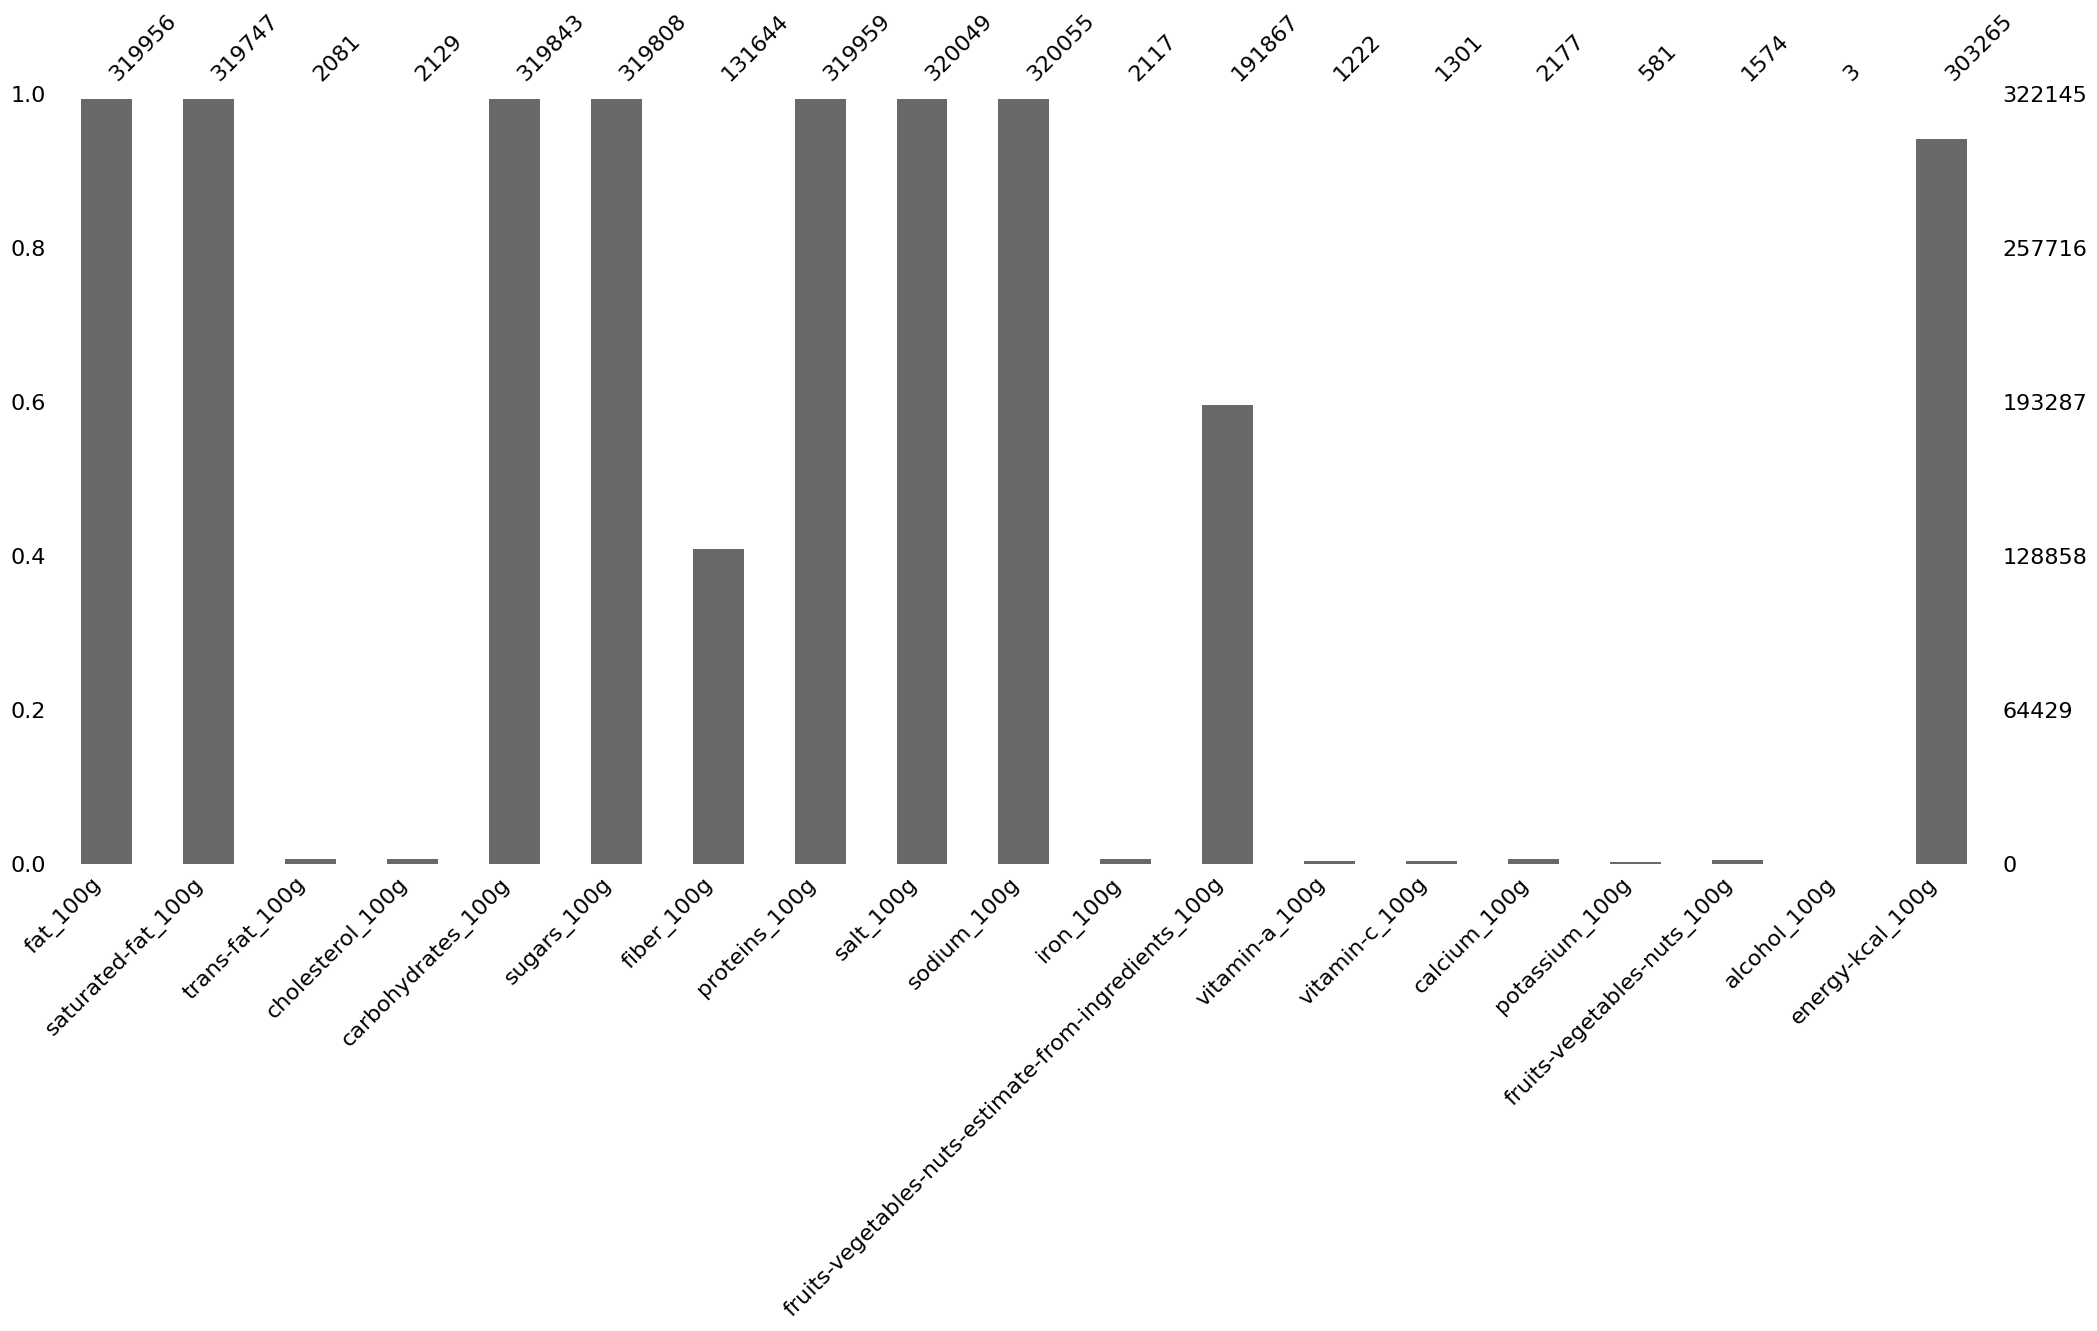

In [46]:
msno.bar(df_filtered1)
plt.show()

### Deleting columns with a more than 70% of missing values

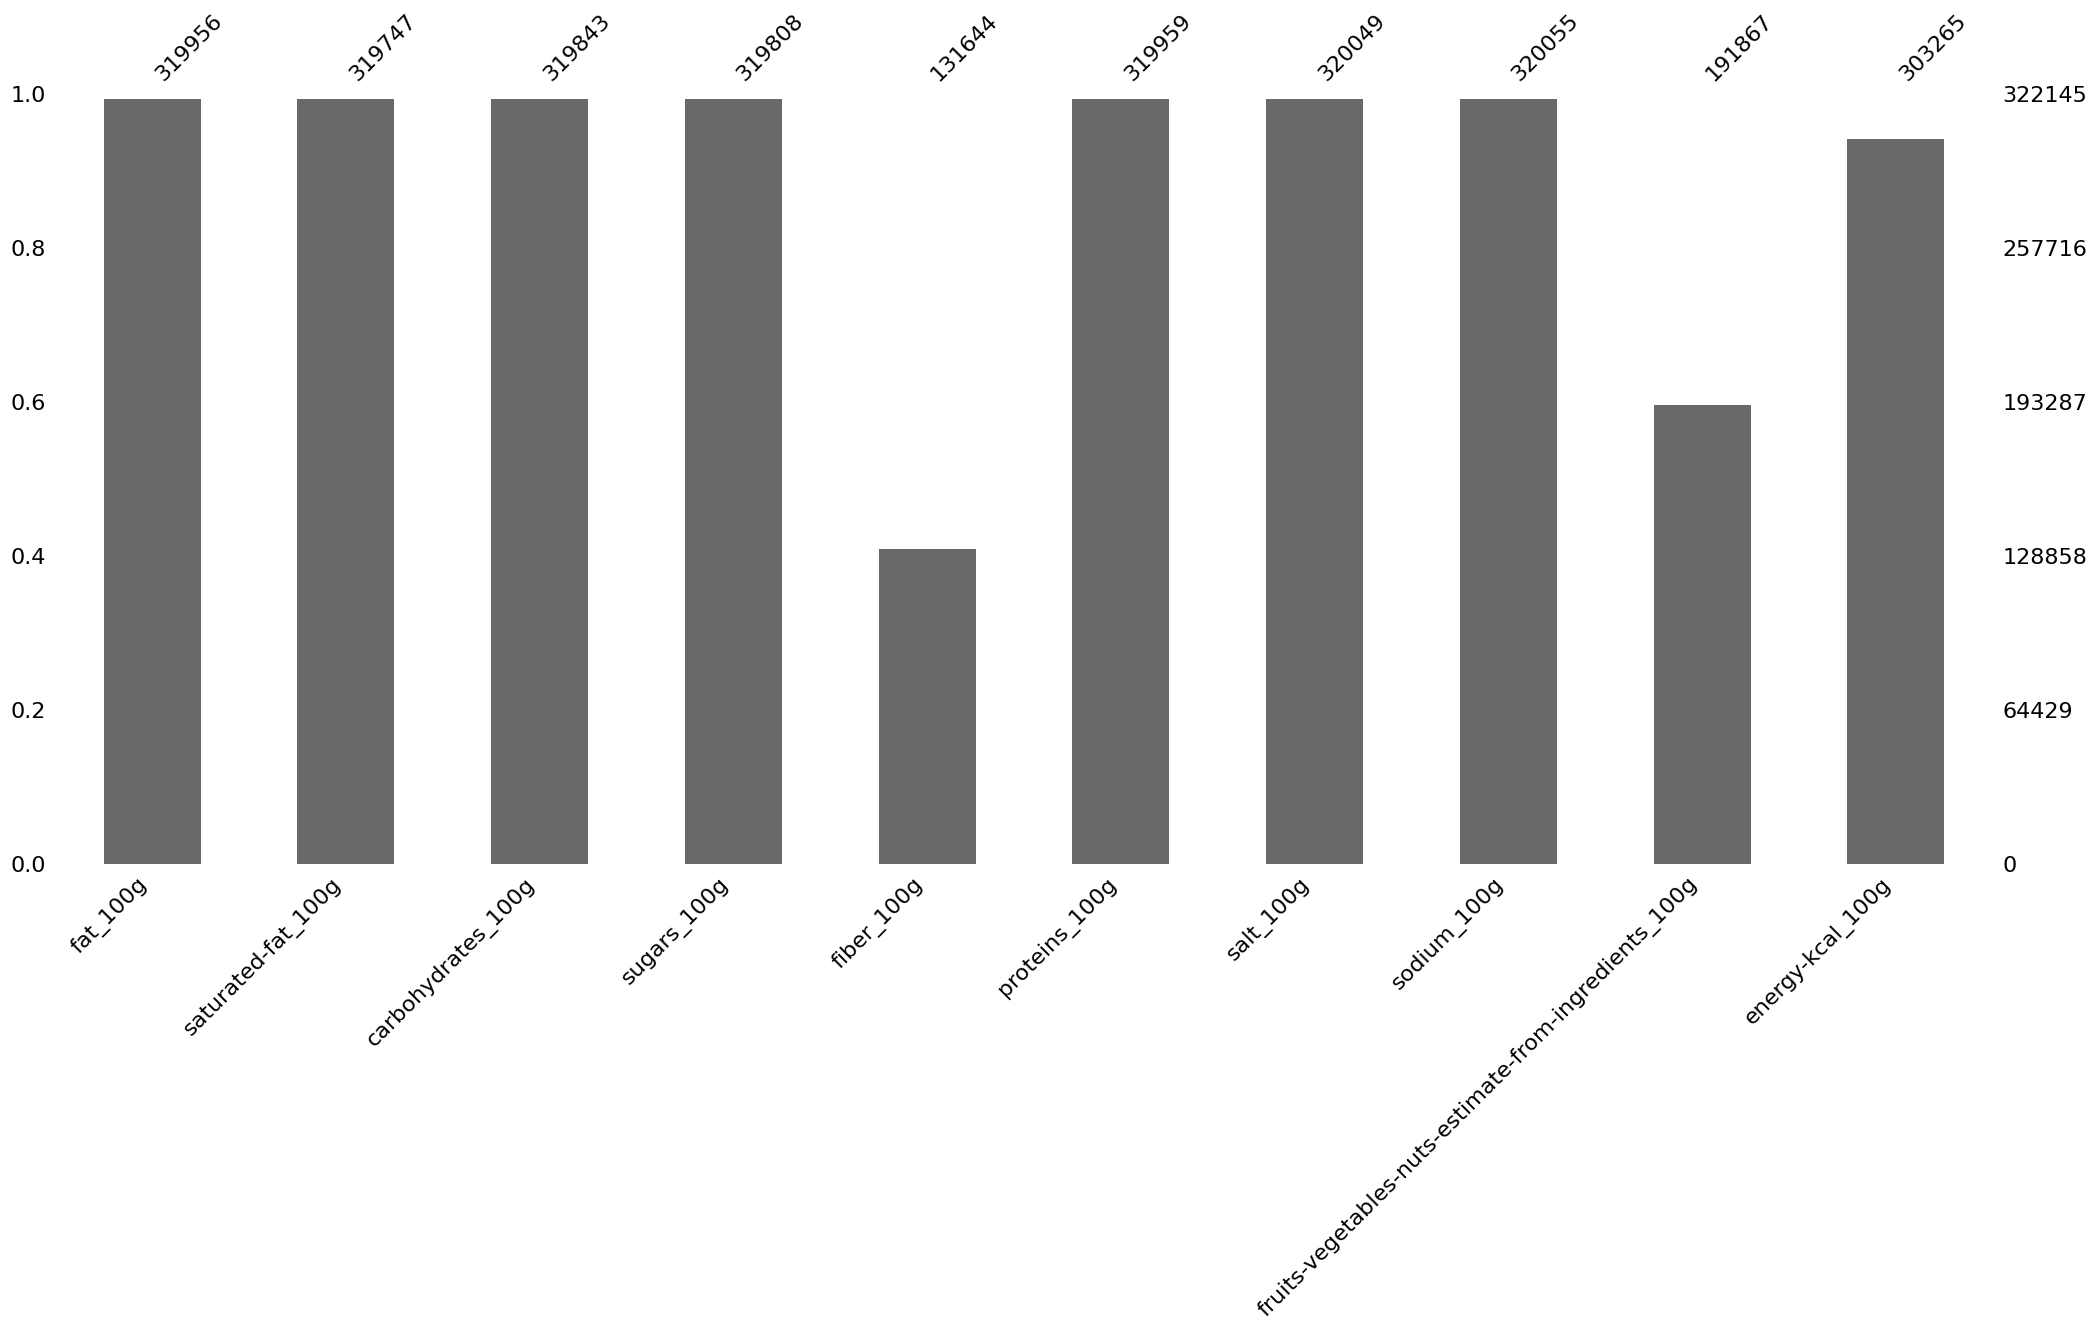

In [47]:
# Delete columns with at least 70% NaN
percentage = 0.70

threshold = int((1 - percentage) * df_filtered1.shape[0])

df_filtered1.dropna(thresh=threshold, inplace= True, axis=1)

msno.bar(df_filtered1)
plt.show()

### Imputations of NaN with median (because there aren't much NaNs)

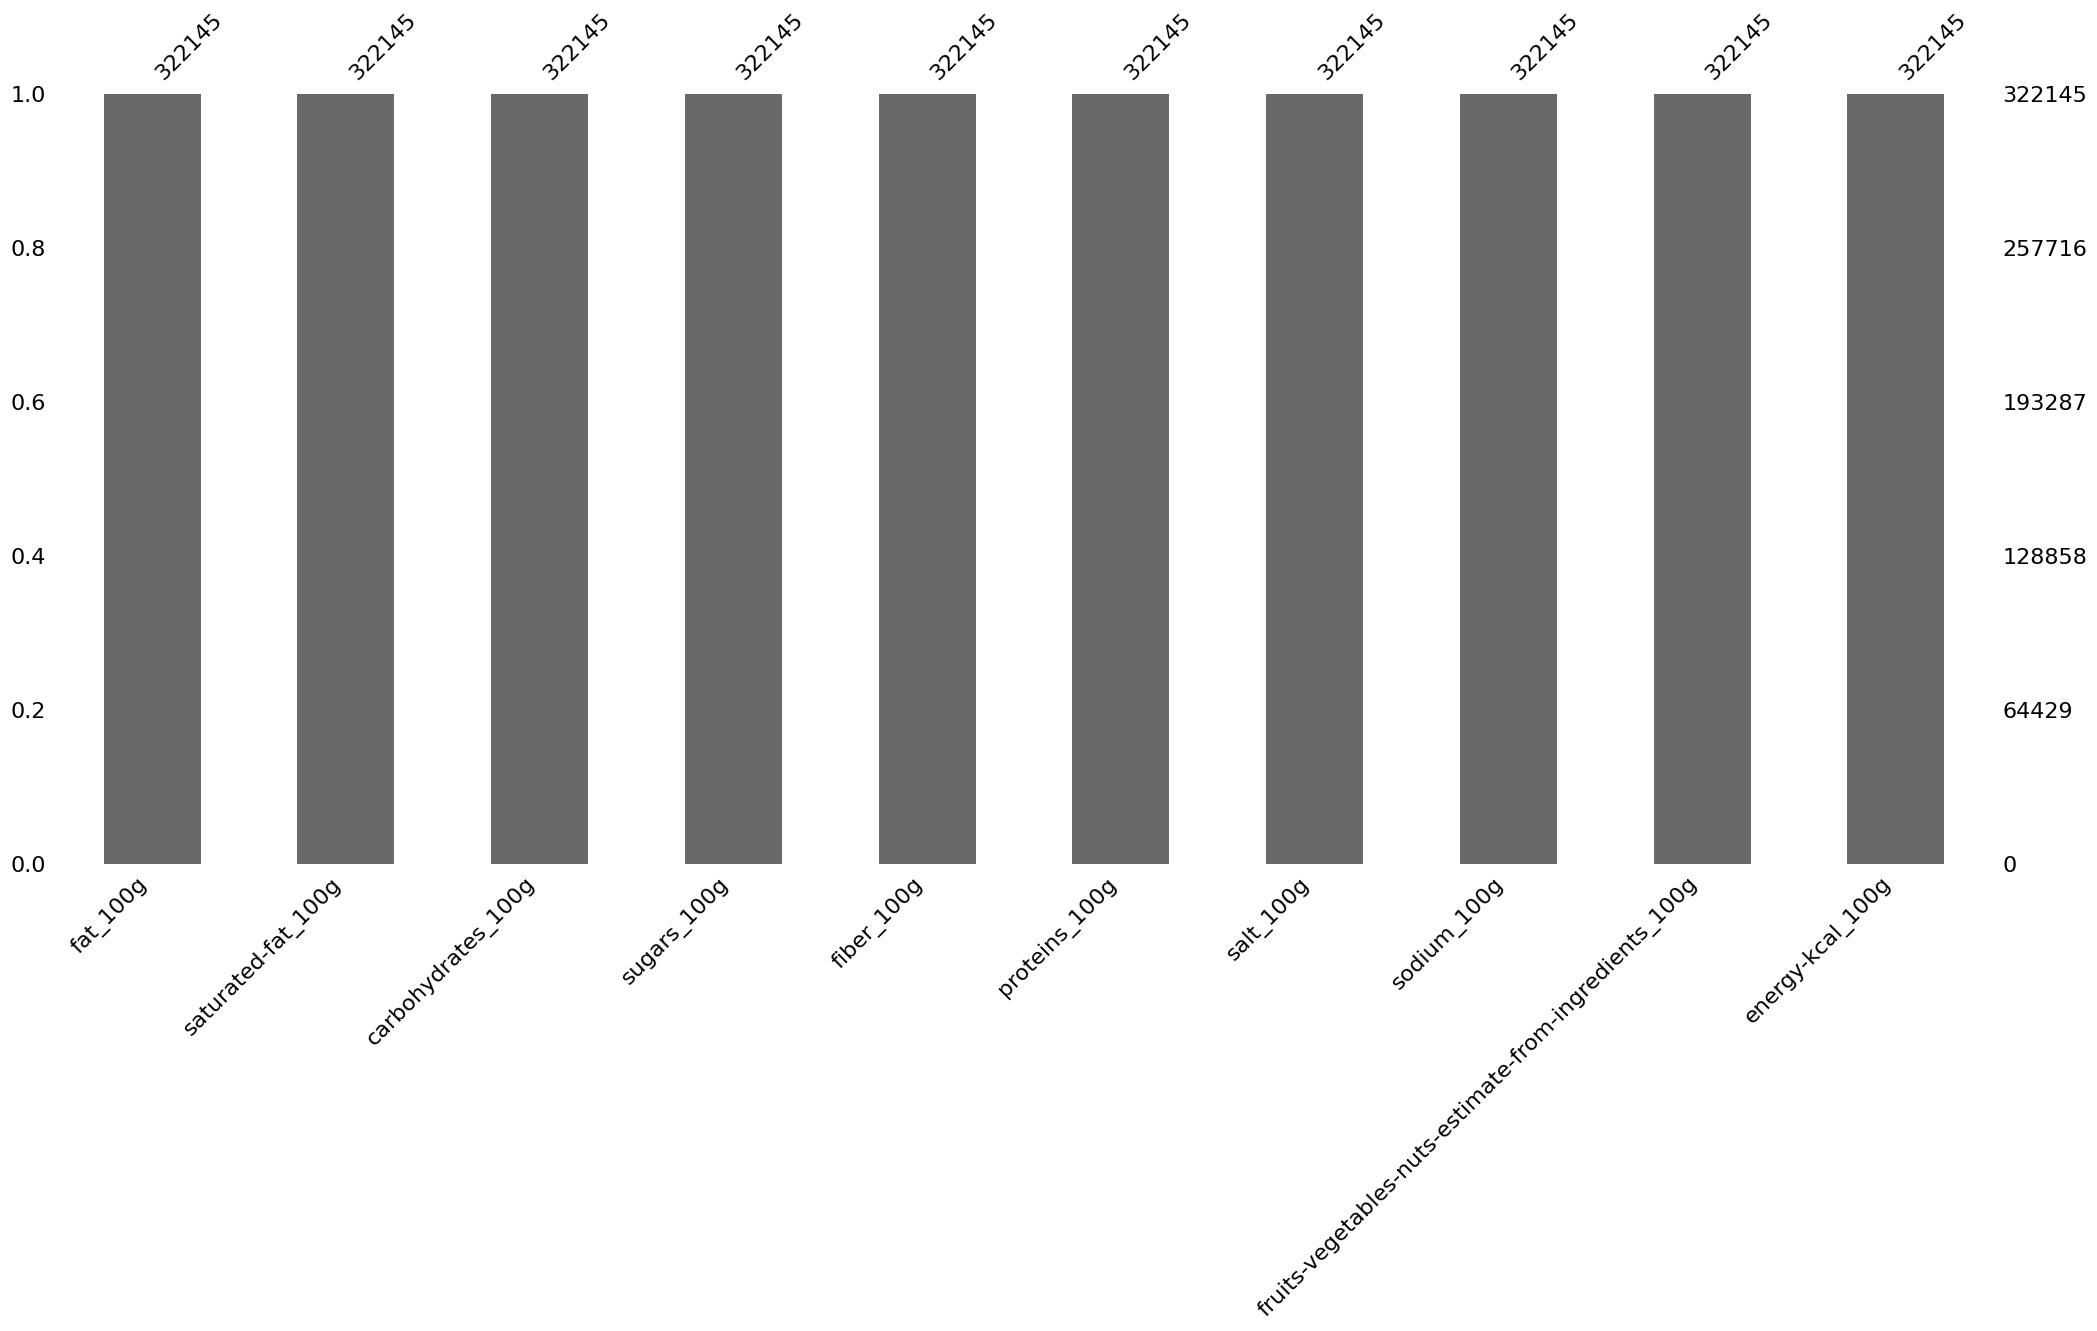

In [48]:
simple_imputer = SimpleImputer(strategy='median')

df_imputed = simple_imputer.fit_transform(df_filtered1)

df_imputed = pd.DataFrame(df_imputed, columns=df_filtered1.columns)

msno.bar(df_imputed)
plt.show()

### Adding the 'pnns_groups_1' column

In [49]:
df_imputed['pnns_groups_1'] = df_filtered['pnns_groups_1']

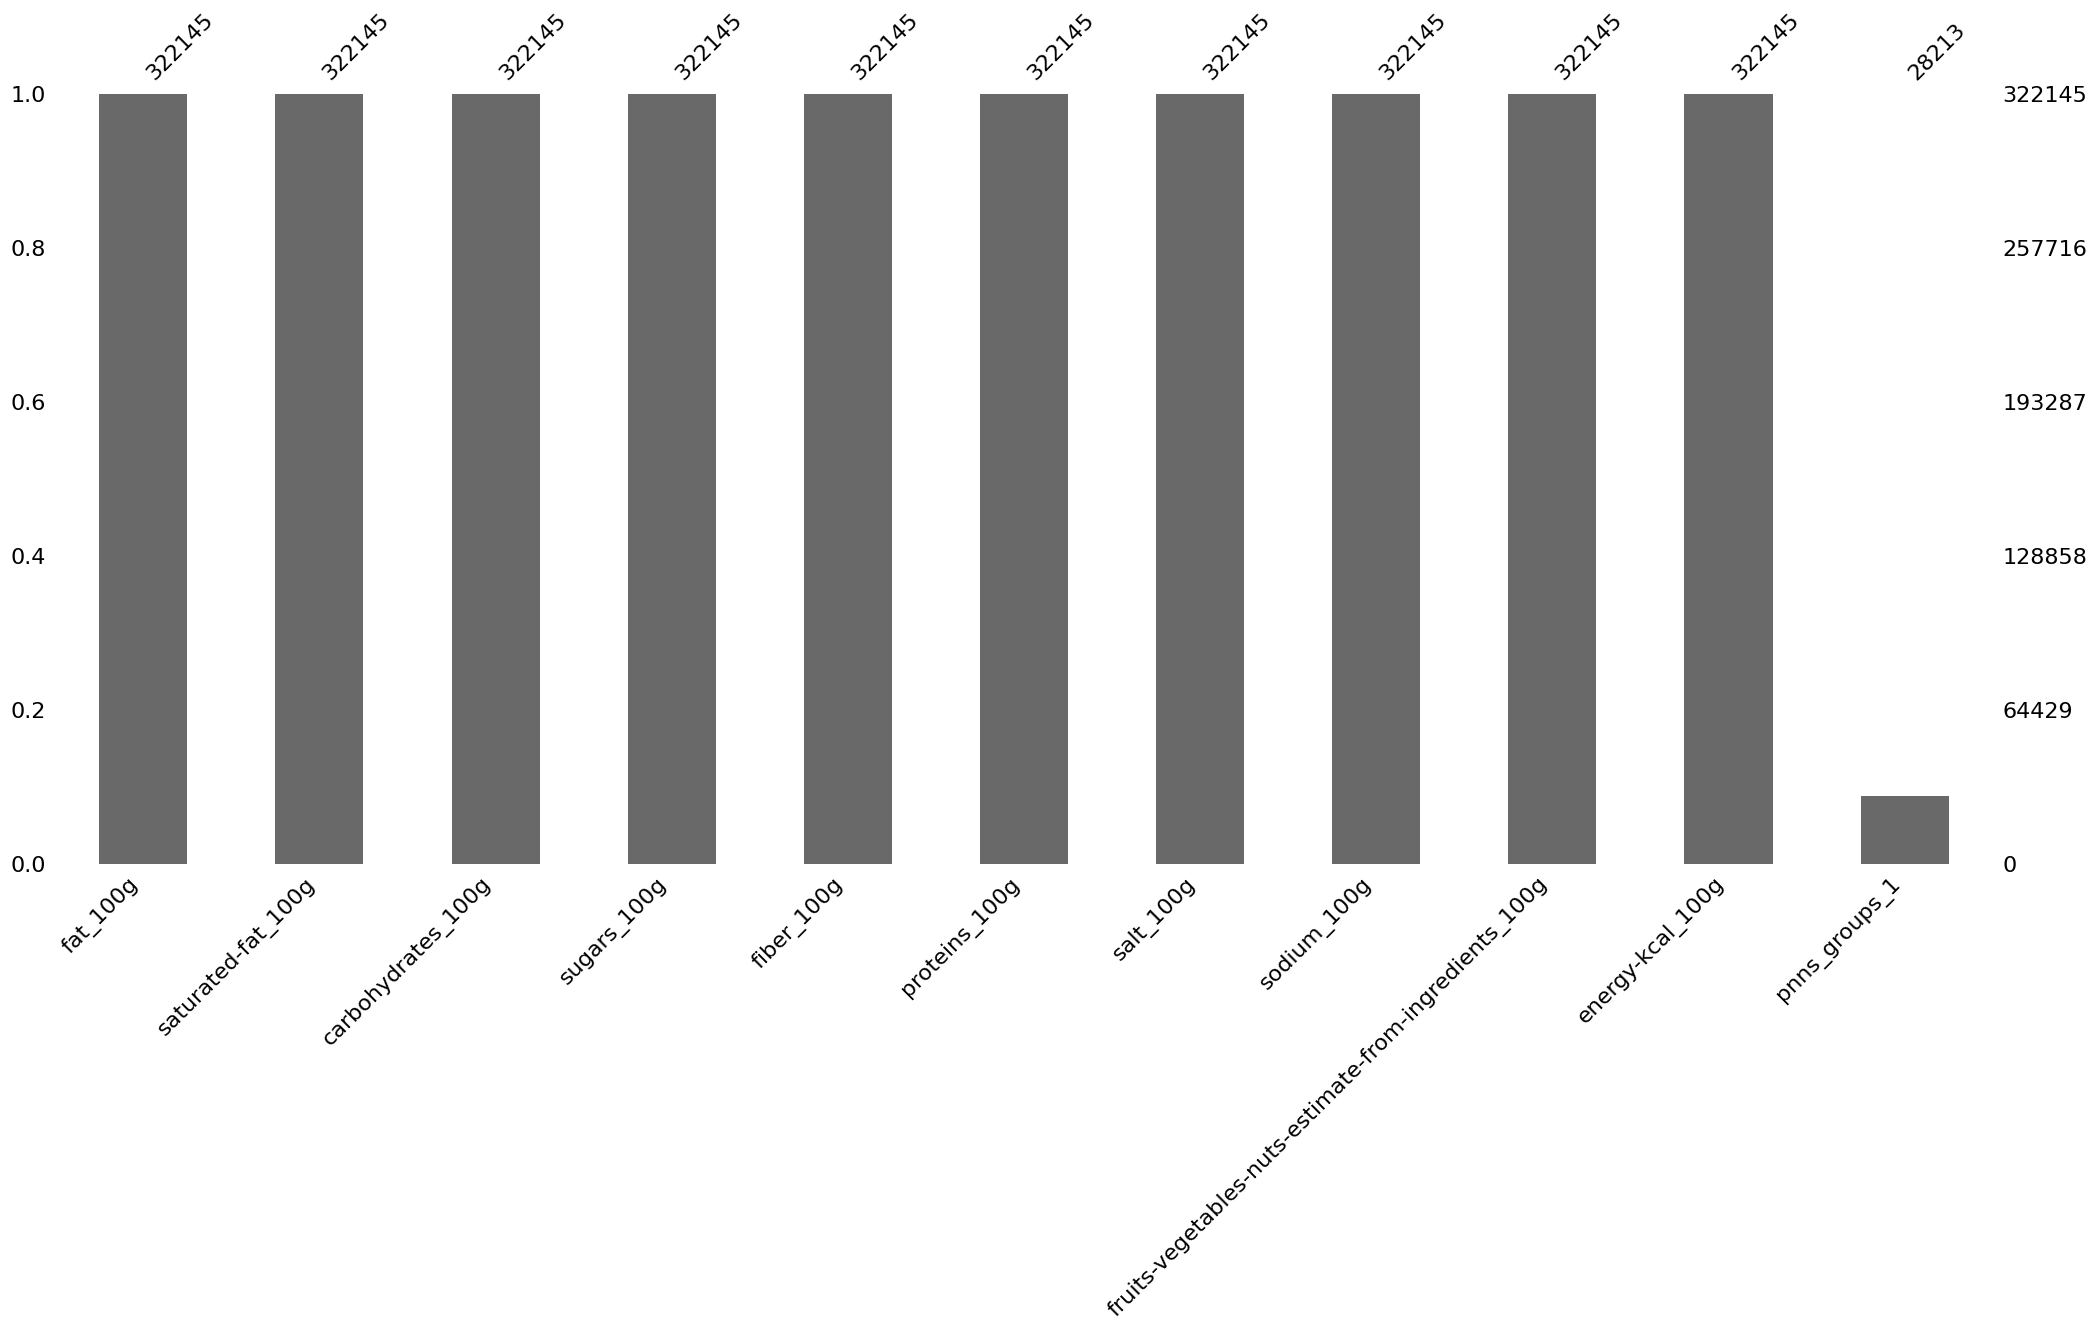

In [50]:
df_imputed.columns

msno.bar(df_imputed)
plt.show()

### Deleting 'pnns_groups_1', because there is too many NaNs

In [51]:
df_imputed = df_imputed.drop('pnns_groups_1', axis=1)

df_imputed.columns

Index(['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'energy-kcal_100g'],
      dtype='object')

In [52]:
df_imputed.to_csv('cleaned_csv/openfoodfacts_nutrients_clean.csv', index=False)